# Variational API Quickstart

[**Original article**](https://docs.pymc.io/notebooks/variational_api_quickstart.html)

The variational inference (VI) API in PyMC3 can be use to approximate posterior distributions for Bayesian models.

In [1]:
from typing import Collection

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = "retina"

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))

sns_blue = "#1F77B4"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pm.set_tt_rng(RANDOM_SEED)

## Setup

Begin with an example of modeling a mixture model.

In [2]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

The expectations for this model cannot be computed analytically, but an approximation can be found using MCMC methods (e.g. NUTS).

In [3]:
with model:
    pm.Deterministic("x2", x2)
    pm.Deterministic("sin_x", sin_x)

    trace = pm.sample(50000)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 59 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


We can plot the traces for $x^2$ and $\sin(x)$ and see the clear multi-modality of the model.

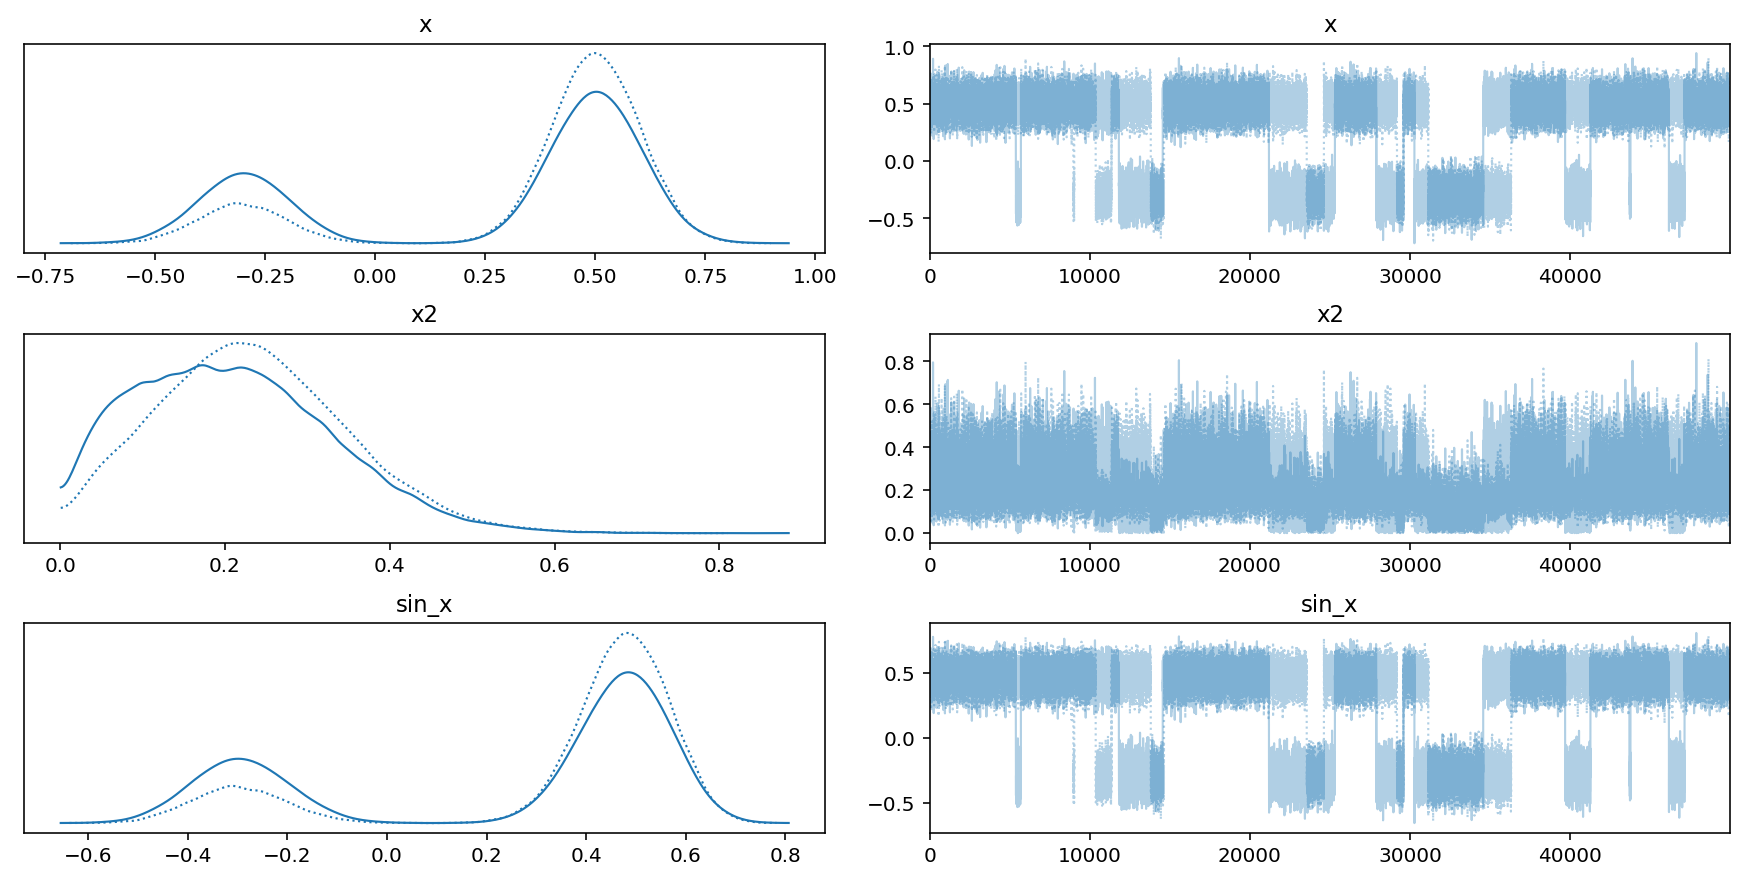

In [4]:
az.plot_trace(az.from_pymc3(trace=trace, model=model));

One drawback of the above approach is that we need to know in advance what we want to see in the trace and wrap it with `pm.Deterministic()`.

The VI API takes an alternate approach: we obtain inference from the model, then calculate expressions based on the model.

We will use the same model as an example.

In [5]:
with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

    mean_field = pm.fit(method="advi")

Finished [100%]: Average Loss = 2.2687


We can see below that ADVI has failed to approximate the multimodel distribution because it uses a Gaussian distribution with a single mode.

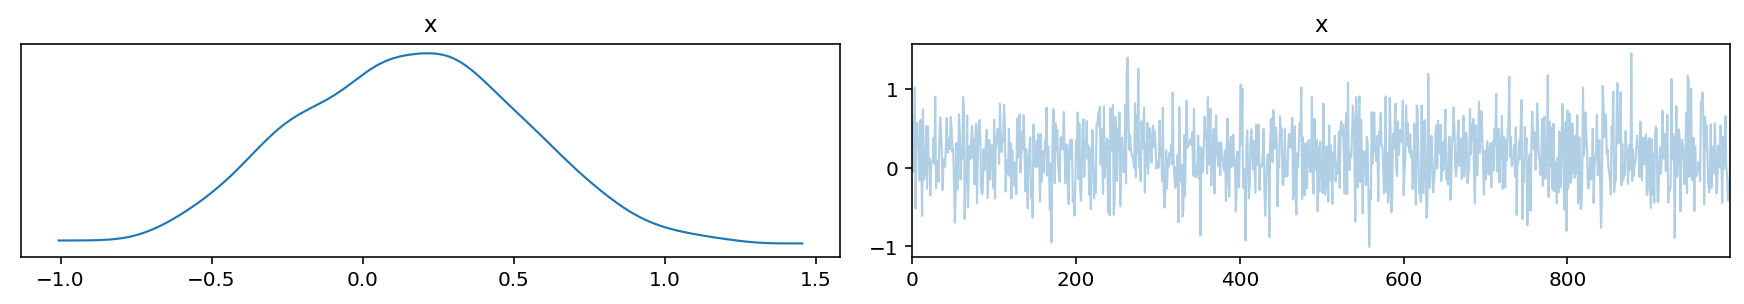

In [6]:
az.plot_trace(az.from_pymc3(trace=mean_field.sample(1000), model=model));

## Checking convergence

We can use the `pm.callbacks.CheckParametersConvergence()` callback to check if the VI converges.

In [7]:
with model:
    mean_field = pm.fit(
        method="advi", callbacks=[pm.callbacks.CheckParametersConvergence()]
    )

Finished [100%]: Average Loss = 2.2763


We can access the inference history in the `.hist` attribute of the `mean_field` object.

In [8]:
def plot_vi_hist(mf: pm.variational.approximations.MeanField) -> gg.ggplot:
    d = pd.DataFrame({"hist": mf.hist, "step": np.arange(len(mf.hist))})
    return (
        gg.ggplot(d, gg.aes(x="step", y="hist"))
        + gg.geom_line(color=sns_blue, alpha=0.8)
        + gg.labs(x="step", y="inference")
    )

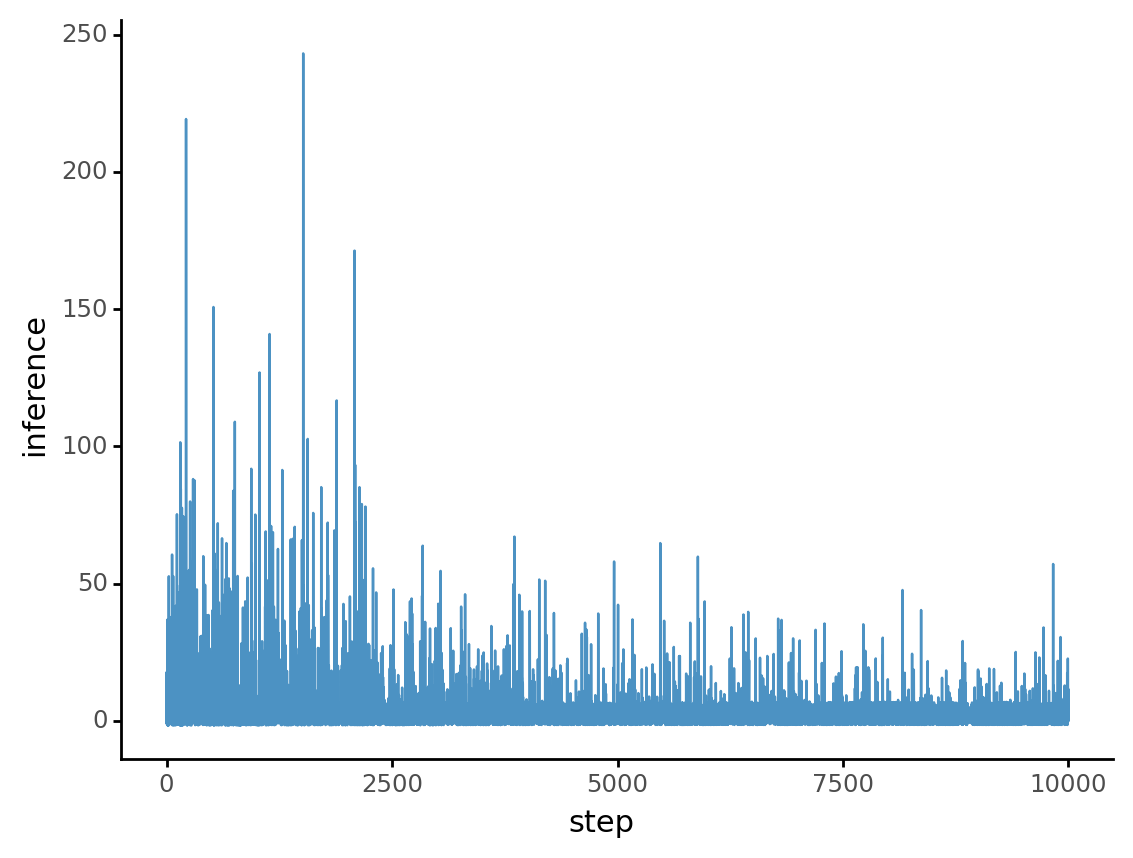

<ggplot: (355797438)>

In [9]:
plot_vi_hist(mean_field)

This is not a good convergence plot, even though we ran many iterations.
It is poor because the mean of the ADVI approximation is close to 0.
Therefore, taking the relative difference (the default method, `diff="relative"`) is unstable for checking convergence.
We can fix this by setting the `diff` parameter of the callback to `"absolute"`.

In [10]:
with model:
    mean_field = pm.fit(
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")],
    )

Convergence achieved at 4700
Interrupted at 4,699 [46%]: Average Loss = 4.7996


Now, we can see that convergence is achieved much sooner at 4,700 steps.

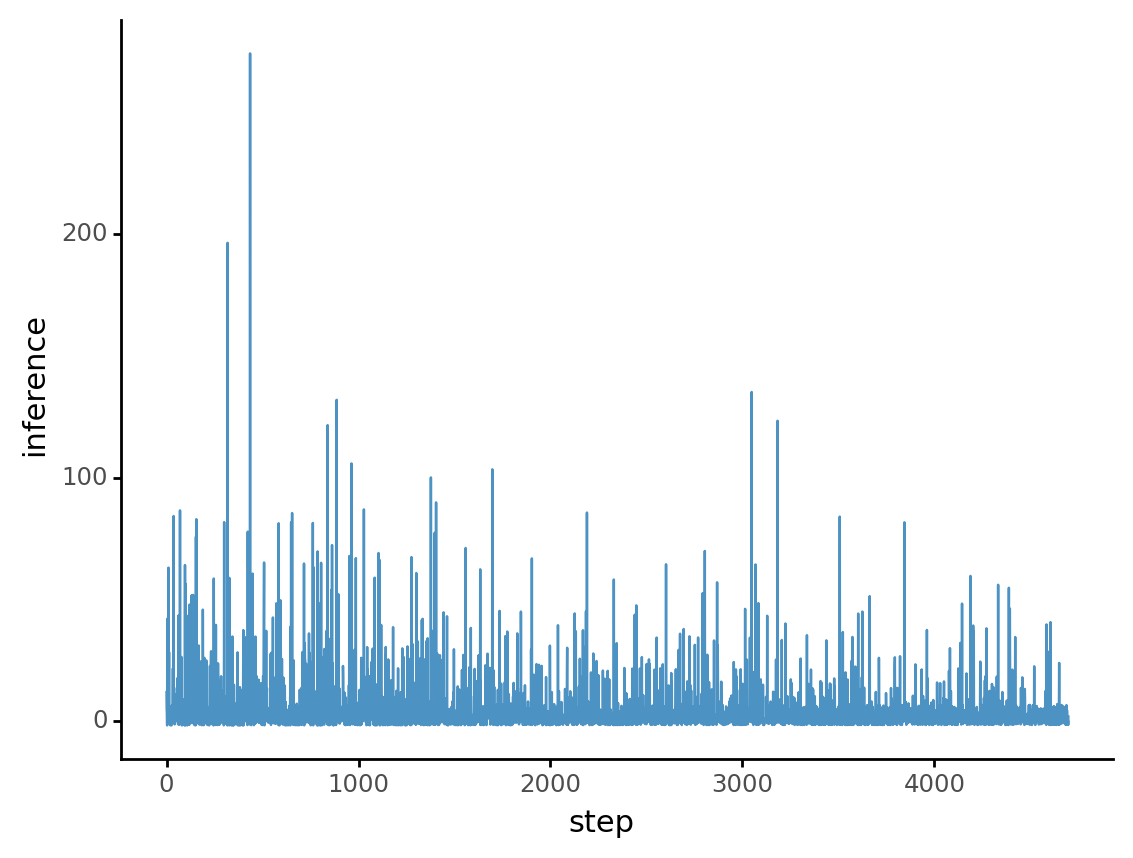

<ggplot: (355826261)>

In [11]:
plot_vi_hist(mean_field)

## Tracking parameters

The `Tracker` callback can be used to track parameters during the fitting process.
Note that this can be a memory-intensive callback.
When using the `fit()` function, we do not have access to the approximation before inference, but tracking parameters requires access to the approximation.
This constraint can be evaded by iusing the object-oriented (OO) API for inference.

In [12]:
with model:
    advi = pm.ADVI()

In [13]:
advi.approx

Different approximations have different hyperparameters.
In mean-field ADVI, we have $\rho$ and $\mu$.

In [14]:
advi.approx.shared_params

{'mu': mu, 'rho': rho}

There are some convient shortcuts to important statistics associated with the approximation.

In [15]:
advi.approx.mean.eval(), advi.approx.std.eval()

(array([0.34]), array([0.69314718]))

We can wrap these statistics within the `Tracker` callback.

In [16]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,
    std=advi.approx.std.eval,
)

In [17]:
approx = advi.fit(20000, callbacks=[tracker])

Finished [100%]: Average Loss = 1.9589


We can then plot the mean and standard deviations of the approximation over the ADVI process.

In [18]:
def plot_means_std_hist(
    track_means: Collection[float],
    track_std: Collection[float],
    approx_history: Collection[float],
) -> gg.ggplot:

    titles = ["Mean track", "Std dev track", "Negative ELBO track"]

    d = pd.DataFrame(
        {
            titles[0]: track_means,
            titles[1]: track_std,
            titles[2]: approx_history,
            "x": np.arange(len(track_means)),
        }
    ).melt(id_vars="x", var_name="param", value_name="value")
    d["param"] = pd.Categorical(d.param.values, categories=titles, ordered=True)

    return (
        gg.ggplot(d, gg.aes(x="x", y="value"))
        + gg.facet_wrap("param", nrow=1, scales="free")
        + gg.geom_line(gg.aes(color="param"))
        + gg.scale_x_continuous(expand=(0, 0.02))
        + gg.scale_y_continuous(expand=(0, 0.02))
        + gg.scale_color_brewer(type="qual", palette="Dark2", guide=None)
        + gg.theme(figure_size=(10, 3), subplots_adjust={"wspace": 0.2})
        + gg.labs(x="step", y="value")
    )

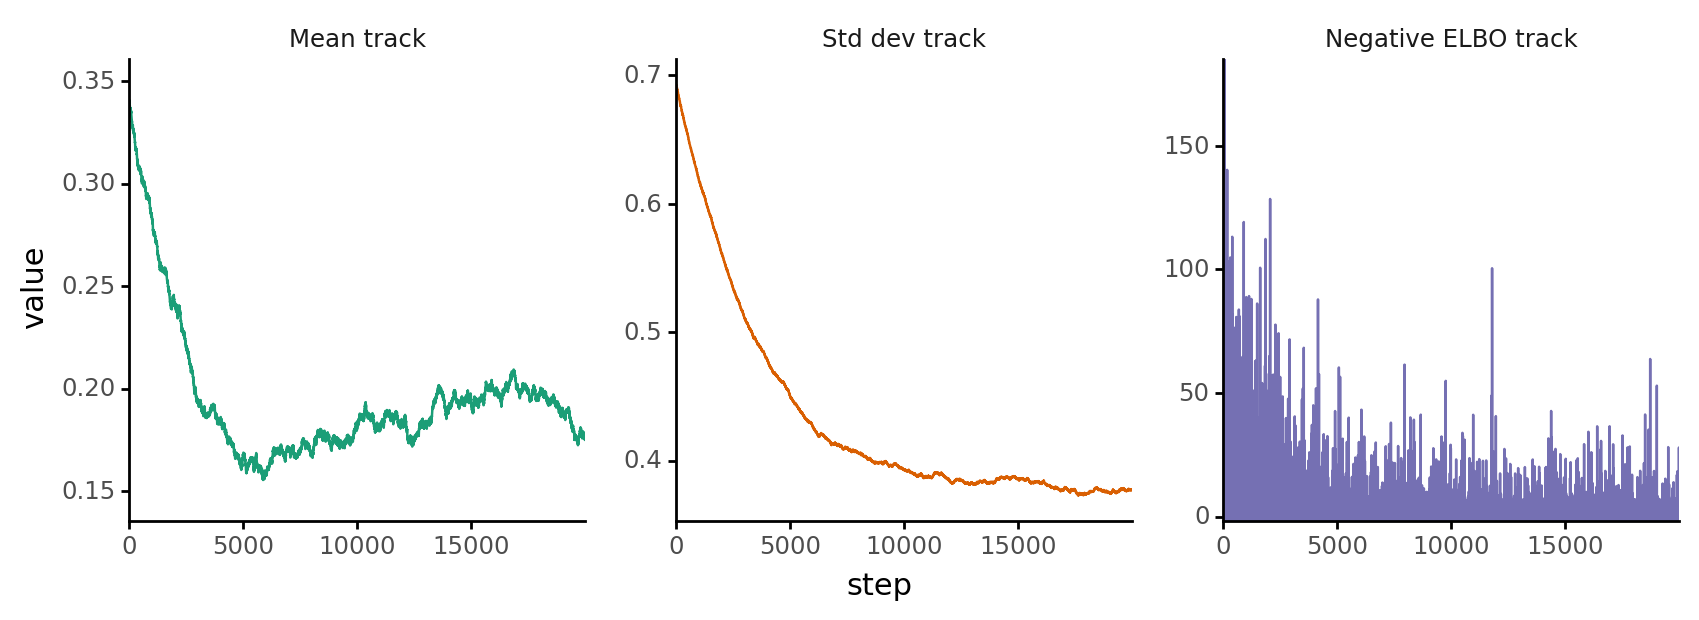

<ggplot: (354908645)>

In [19]:
means = [a[0] for a in tracker["mean"]]
stds = [a[0] for a in tracker["std"]]

plot_means_std_hist(means, stds, advi.hist)

From the plot of the mean, we can see there were convergence issues, though the lack of convergence does not seem to change the ELBO trajectory substantially.
Since we are using the OO API, we can fun the approximation longer until convergence is achieved.

In [20]:
advi.refine(100000)

Finished [100%]: Average Loss = 1.8422


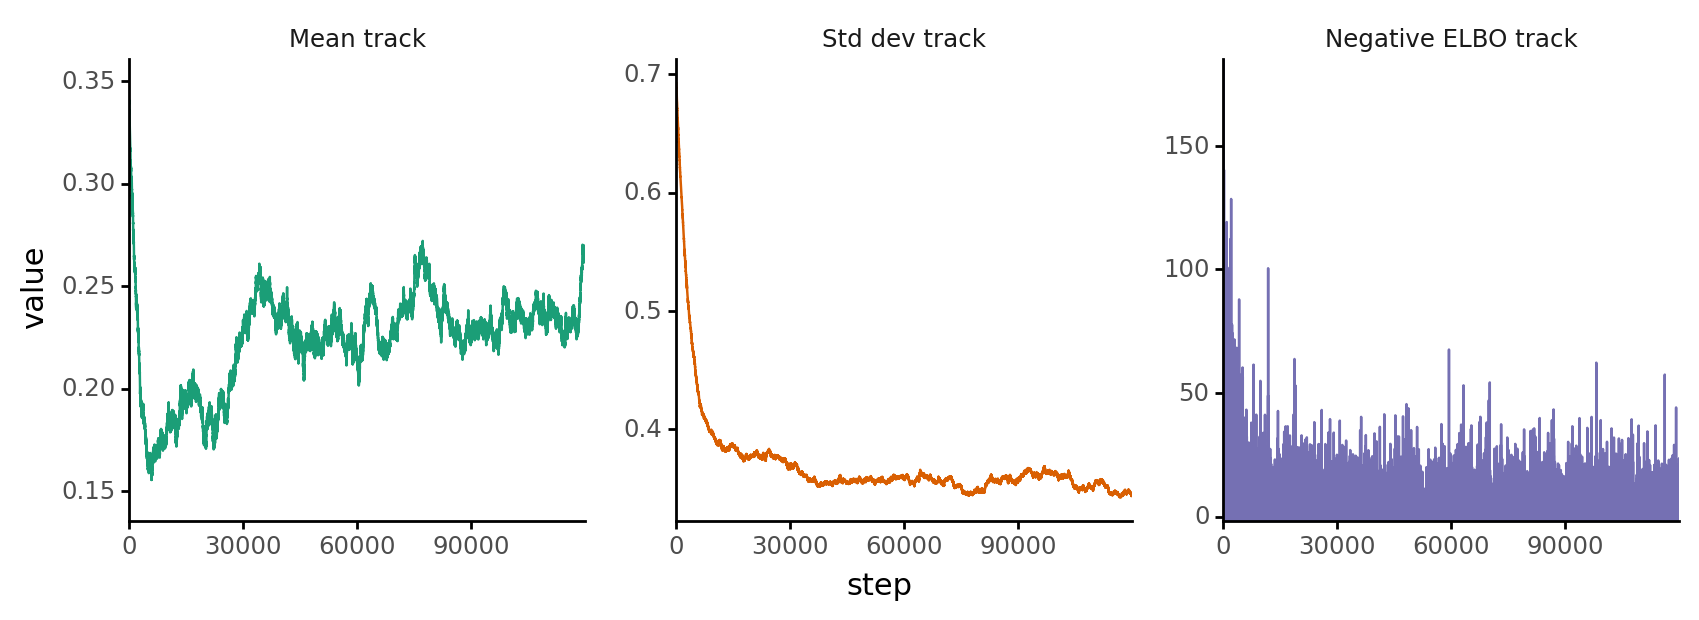

<ggplot: (355486296)>

In [21]:
means = [a[0] for a in tracker["mean"]]
stds = [a[0] for a in tracker["std"]]

plot_means_std_hist(means, stds, advi.hist)

The fact that the mean still looks like a random walk indicates that ADVI still did not converge.
This is likely because ADVI is not the best algorithm for performing inference on this model.
The reuslts are *very* unstable and using different random seeds would produce very different results.

We can see again that ADVI is unable to deal multimodality.

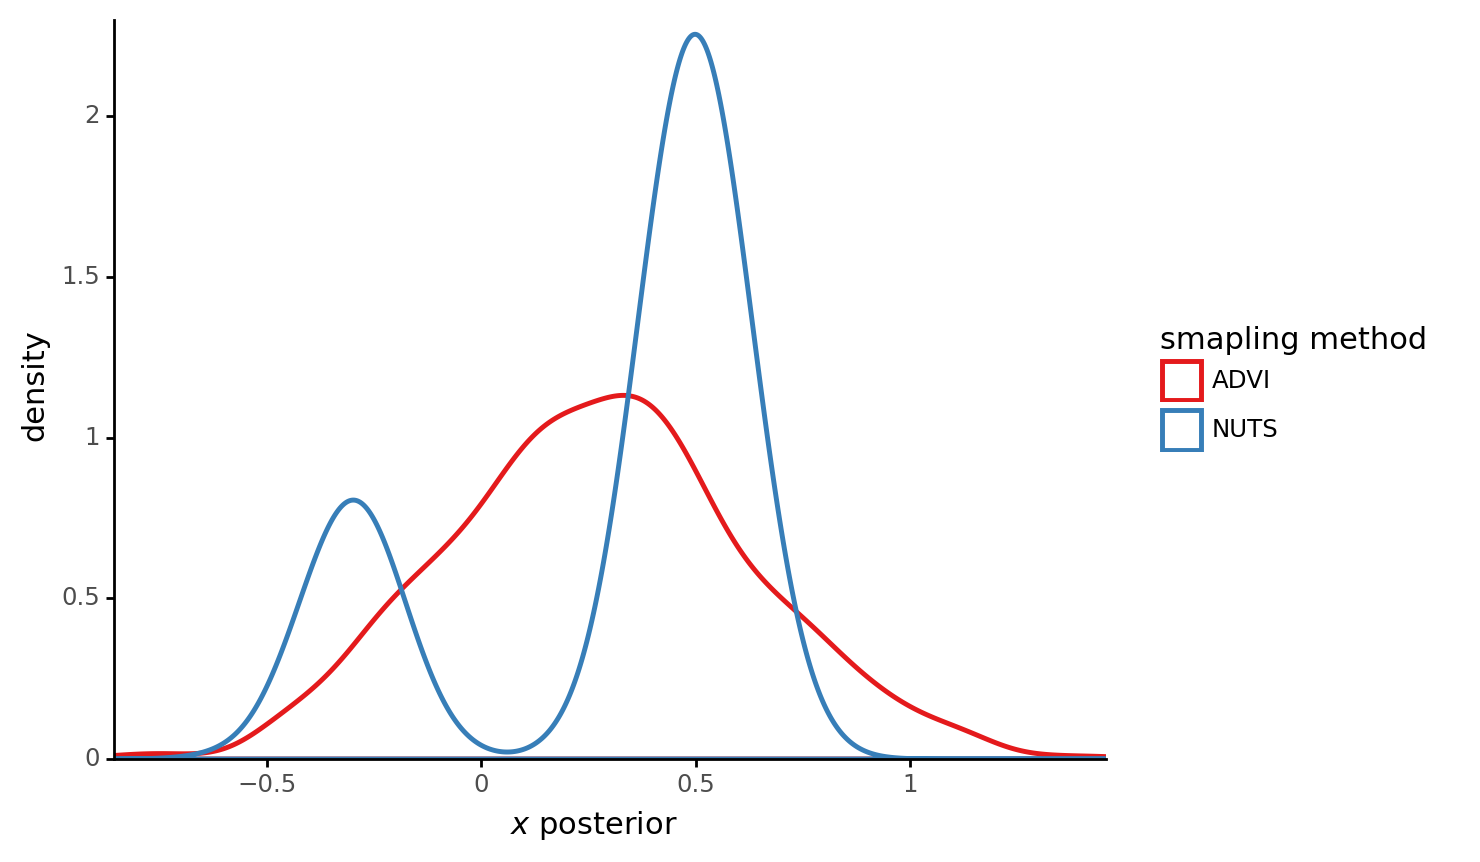

<ggplot: (354875908)>

In [22]:
d = pd.concat(
    [
        pd.DataFrame({"x": np.random.choice(trace["x"], 1000), "label": "NUTS"}),
        pd.DataFrame({"x": approx.sample(1000)["x"], "label": "ADVI"}),
    ]
).reset_index(drop=True)

(
    gg.ggplot(d, gg.aes(x="x", color="label"))
    + gg.geom_density(size=1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="$x$ posterior", y="density", color="smapling method")
)

We can try to use the SVGD algorithm instead since it generates an approximation based on a large number of particles.

In [23]:
with model:
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs={"n_particles": 1000},
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )

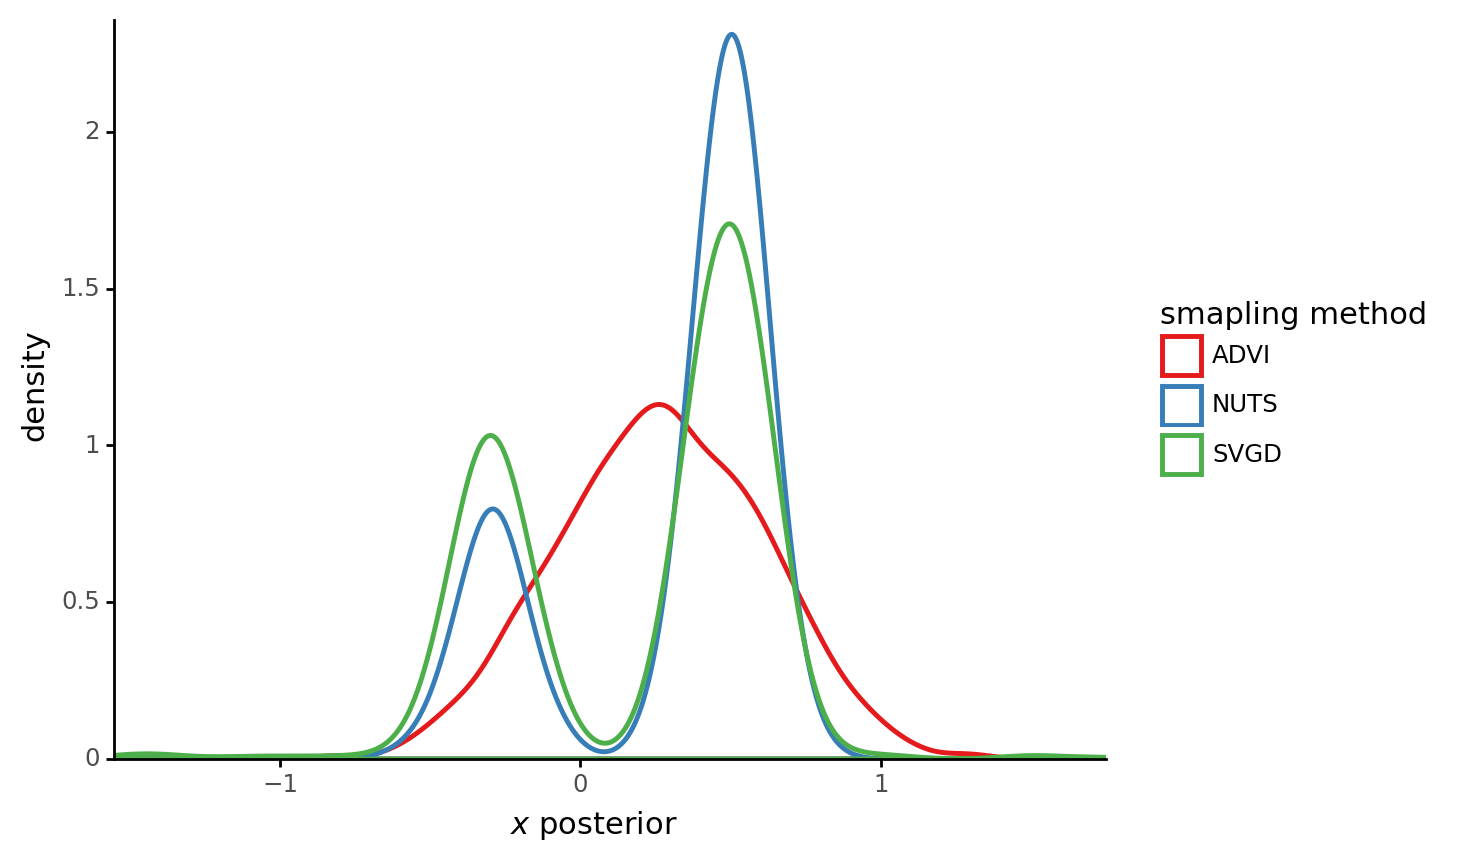

<ggplot: (358493181)>

In [24]:
d = pd.concat(
    [
        pd.DataFrame({"x": np.random.choice(trace["x"], 1000), "label": "NUTS"}),
        pd.DataFrame({"x": approx.sample(1000)["x"], "label": "ADVI"}),
        pd.DataFrame({"x": svgd_approx.sample(1000)["x"], "label": "SVGD"}),
    ]
).reset_index(drop=True)

(
    gg.ggplot(d, gg.aes(x="x", color="label"))
    + gg.geom_density(size=1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="$x$ posterior", y="density", color="smapling method")
)

From this plot, we can see that SVGD was able to identify the multimodal distribution of $x$.

With this approximation, we can calculate arbitrary functions of the parameters.
To evaluate the expressions, use `svgd_approx.sample_node()` and the `eval()` of the sample.

In [25]:
a = x ** 2
b = pm.math.sin(x)

a_sample = svgd_approx.sample_node(a)

# Every evaluation returns a differen value because it is stochastic.
a_sample.eval(), a_sample.eval(), a_sample.eval()

(array(0.37410017), array(0.28284699), array(0.22338846))

We can get many samples using the `size` argument in `.sample_node()`.

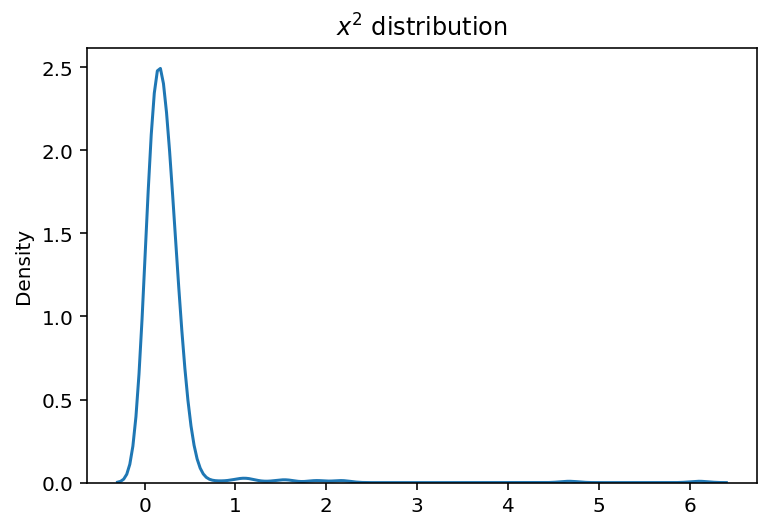

In [26]:
a_samples = svgd_approx.sample_node(a, size=1000)

sns.kdeplot(a_samples.eval())
plt.title("$x^2$ distribution");

In [27]:
# Calculate variance
a_samples.var(axis=0).eval()

array(0.09817046)

In [28]:
# Calculate mean
a_samples.mean(axis=0).eval()

array(0.25033471)

## Multilabel logisitic regression

We will fit a model for multi-label classification of the Iris data set as an example.

In [29]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
num_features = X.shape[1]
num_classes = len(np.unique(y))

In [31]:
Xt = theano.shared(X_train)
yt = theano.shared(y_train)

with pm.Model() as iris_model:

    # Coefficients for features.
    β = pm.Normal("β", 0, 100, shape=(num_features, num_classes))

    # Transform to unit interval.
    a = pm.Flat("a", shape=(num_classes,))
    p = tt.nnet.softmax(Xt.dot(β) + a)

    observed = pm.Categorical("obs", p=p, observed=yt)

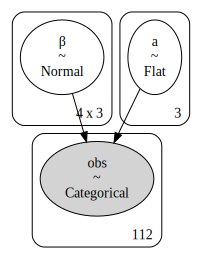

In [32]:
pm.model_to_graphviz(iris_model)

PyMC3 models have symbolic inputs for latent variables.
Fixed values need to be provided to evaluate an expression that requires knolwedge of these latent variables.
These values can come from VI approximations.

The `.sample_node()` method removes the symbolic dependencies.

In [33]:
with iris_model:

    # Use SVGD algorithm.
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Create a local reference to the approximation.
    approx = inference.approx

    train_probs = approx.sample_node(p)
    test_probs = approx.sample_node(p, more_replacements={Xt: X_test}, size=100)

We now have 100 sampled probabilities for each data point.

We can create symbolic expressions for measuring accuracy.

In [34]:
test_ok = tt.eq(test_probs.argmax(-1), y_test)
train_ok = tt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval, train_accuracy=train_accuracy.eval
)

inference.fit(200, callbacks=[eval_tracker])

We can now plot the training and test accuracy over the fitting process.

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


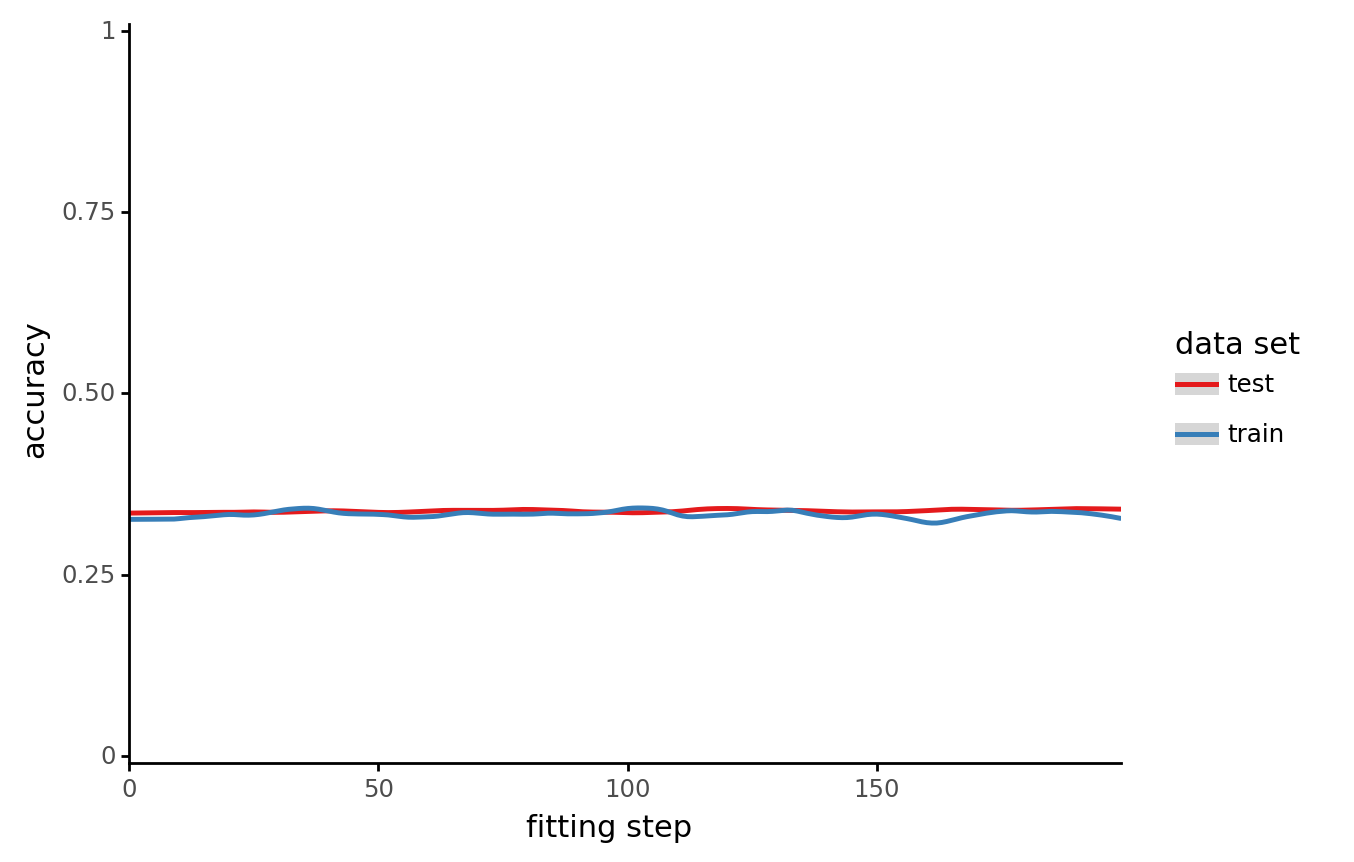

<ggplot: (356258753)>

In [35]:
accuracy_results = pd.concat(
    [
        pd.DataFrame(eval_tracker["test_accuracy"])
        .T.melt(var_name="step", value_name="acc")
        .assign(label="test"),
        pd.DataFrame(eval_tracker["train_accuracy"], columns=["acc"])
        .assign(label="train")
        .assign(step=np.arange(len(eval_tracker["train_accuracy"]))),
    ]
)

(
    gg.ggplot(accuracy_results, gg.aes(x="step", y="acc"))
    + gg.geom_smooth(gg.aes(group="label", color="label"), method="lowess", span=0.1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(limits=(0, 1), expand=(0, 0.01))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="fitting step", y="accuracy", color="data set")
)

It does not look like this worked at all.

We can try a different optimizer to boost the learning rate.

In [36]:
inference.fit(400, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker])

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


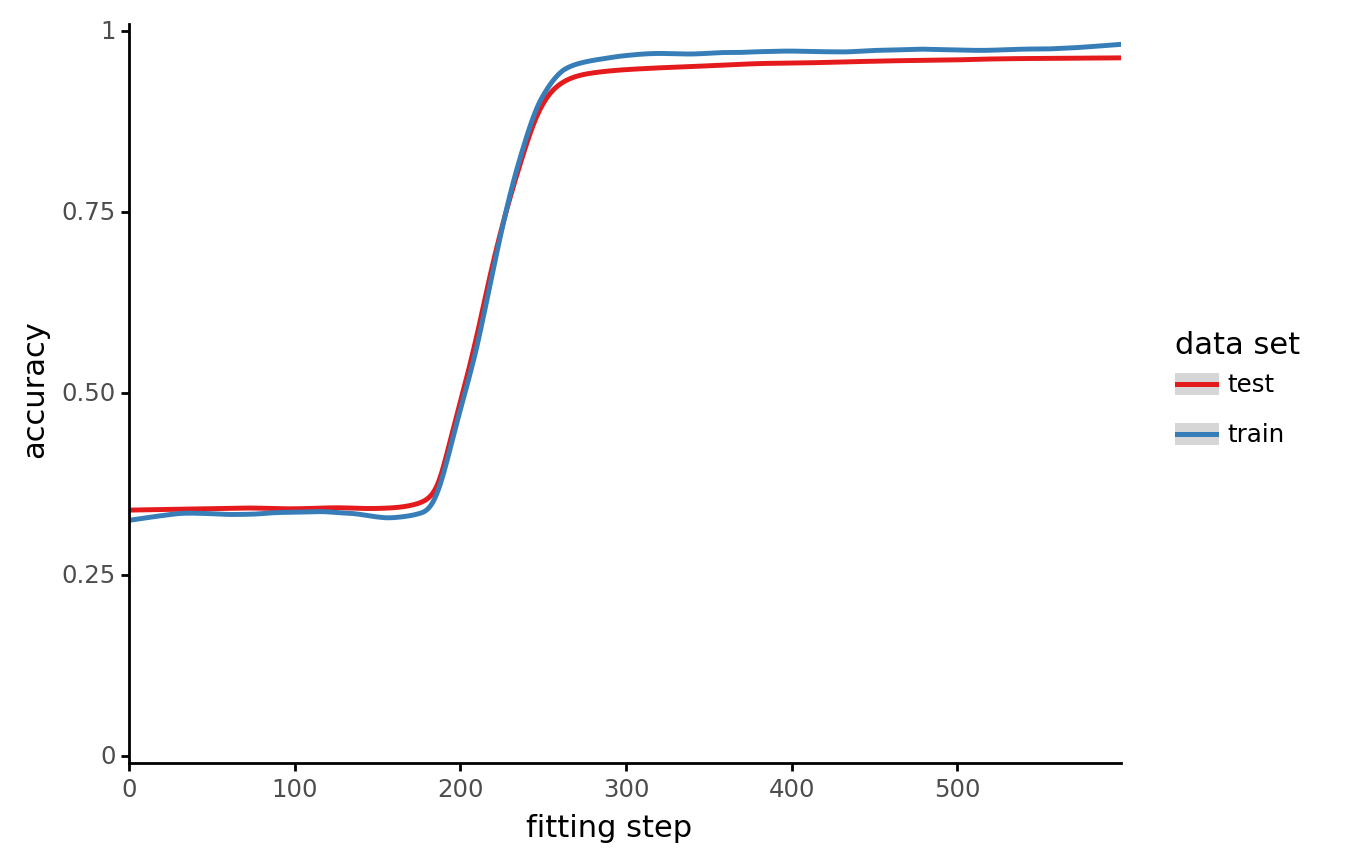

<ggplot: (355416068)>

In [37]:
accuracy_results = pd.concat(
    [
        pd.DataFrame(eval_tracker["test_accuracy"])
        .T.melt(var_name="step", value_name="acc")
        .assign(label="test"),
        pd.DataFrame(eval_tracker["train_accuracy"], columns=["acc"])
        .assign(label="train")
        .assign(step=np.arange(len(eval_tracker["train_accuracy"]))),
    ]
)

(
    gg.ggplot(accuracy_results, gg.aes(x="step", y="acc"))
    + gg.geom_smooth(gg.aes(group="label", color="label"), method="lowess", span=0.1)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(limits=(0, 1), expand=(0, 0.01))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="fitting step", y="accuracy", color="data set")
)

Changing to a Adamax training schedule seems to have worked.

## Minibatches

Minibatch training can be used to speed up and improve approximation when using large datasets.
Use the `pm.Minibatch` class which is just a specialized Theano tensor.

As an example, we will generate a large dataset.

In [38]:
data = np.random.rand(40000, 100)
data *= np.random.randint(1, 10, size=(100,))
data += np.random.rand(100) * 10

For comparison we will fit the model with and without minibatching.

In [39]:
with pm.Model() as model:
    mu = pm.Flat("mu", shape=(100,))
    sd = pm.HalfNormal("sd", shape=(100,))
    lik = pm.Normal("lik", mu, sd, observed=data)

To not waste too much time, we can create a callback to stop the approximation after 100 steps.

In [40]:
def stop_after_100(approx, loss_history, i):
    if i == 100:
        raise StopIteration("Stopping approximation.")

In [41]:
with model:
    advifit = pm.fit(callbacks=[stop_after_100])

Stopping approximation.
Interrupted at 99 [0%]: Average Loss = 6.2211e+08


Now we can use minibatching.

> Rembember to set the `total_size` parameter in the observed variable!

In [42]:
X_batch = pm.Minibatch(data, batch_size=500)

with pm.Model() as model:
    mu = pm.Flat("mu", shape=(100,))
    sd = pm.HalfNormal("sd", shape=(100,))
    likelihood = pm.Normal(
        "likelihood", mu, sd, observed=X_batch, total_size=data.shape
    )

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


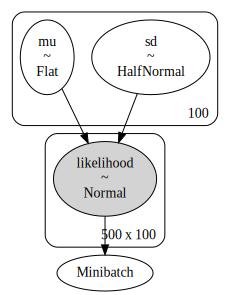

In [43]:
pm.model_to_graphviz(model)

In [44]:
with model:
    advifit = pm.fit()

Finished [100%]: Average Loss = 1.5636e+05


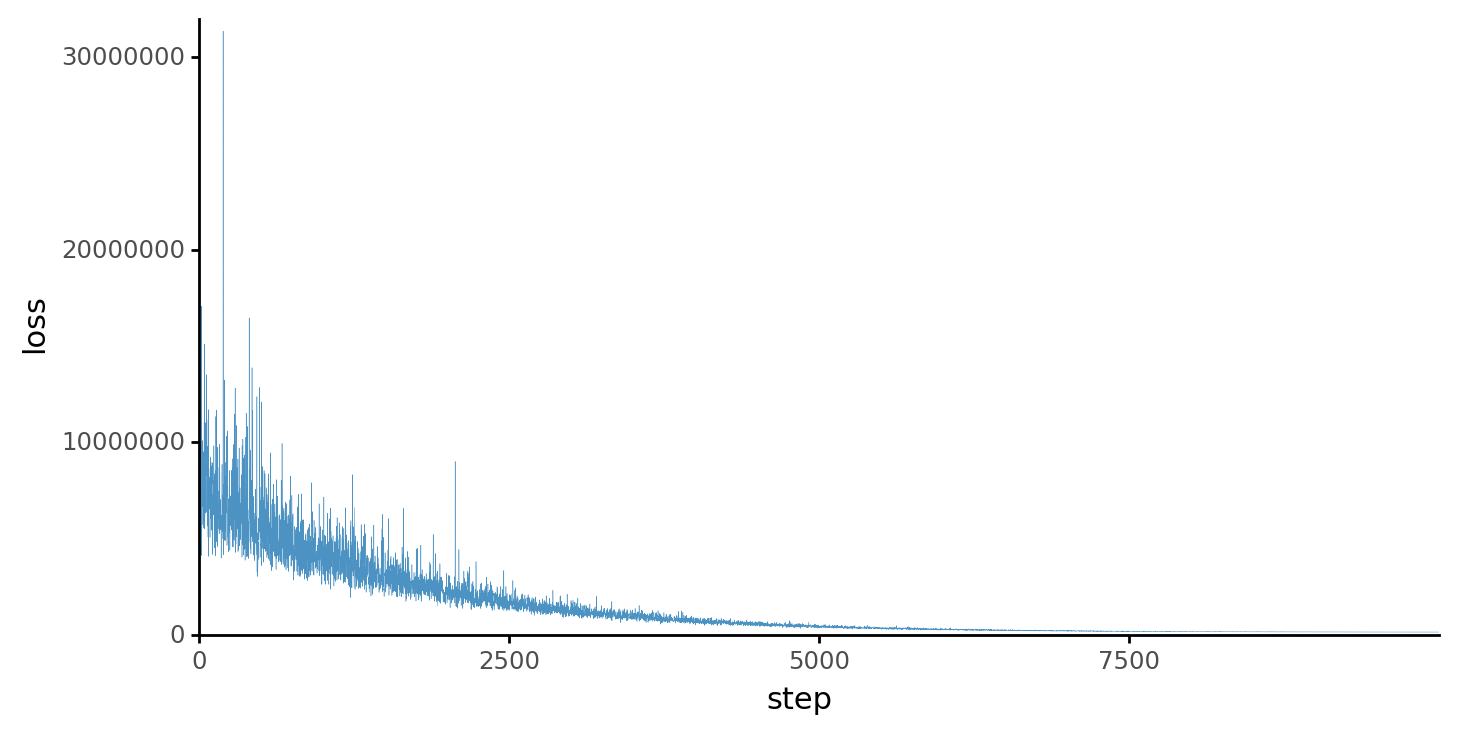

<ggplot: (365782583)>

In [45]:
d = pd.DataFrame({"loss": advifit.hist, "x": np.arange(len(advifit.hist))})

(
    gg.ggplot(d, gg.aes("x", "loss"))
    + gg.geom_line(alpha=0.8, size=0.1, color=sns_blue)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0), limits=(0, np.nan))
    + gg.labs(x="step", y="loss")
    + gg.theme(figure_size=(8, 4))
)

In [46]:
print(pm.Minibatch.__doc__)

Multidimensional minibatch that is pure TensorVariable

    Parameters
    ----------
    data: np.ndarray
        initial data
    batch_size: ``int`` or ``List[int|tuple(size, random_seed)]``
        batch size for inference, random seed is needed
        for child random generators
    dtype: ``str``
        cast data to specific type
    broadcastable: tuple[bool]
        change broadcastable pattern that defaults to ``(False, ) * ndim``
    name: ``str``
        name for tensor, defaults to "Minibatch"
    random_seed: ``int``
        random seed that is used by default
    update_shared_f: ``callable``
        returns :class:`ndarray` that will be carefully
        stored to underlying shared variable
        you can use it to change source of
        minibatches programmatically
    in_memory_size: ``int`` or ``List[int|slice|Ellipsis]``
        data size for storing in ``theano.shared``

    Attributes
    ----------
    shared: shared tensor
        Used for storing data
    m

---

In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Feb 18 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

pandas    : 1.2.2
numpy     : 1.20.1
theano    : 1.1.2
seaborn   : 0.11.1
matplotlib: 3.3.4
plotnine  : 0.7.1
pymc3     : 3.11.1
arviz     : 0.11.1

Watermark: 2.1.0

